In [ ]:

import numpy as np
import segmentation.reggrow.build.lib.reggrow as rg
pcd = rg.PointCloud.from_ply("./data/demo.ply", True)
isinstance_inds = np.ones(pcd.size, dtype=np.int32) * -1
rg.region_growing(
    pcd,
    isinstance_inds,
    1,1,1,
    verbose=False
)

Loading ./data/demo.ply
Read 942188 points
Info: Generated by CloudCompare!
Fields: vertex: x, y, z, red, green, blue, scalar_Original_cloud_index, 
DEBUG: init parameters
Building KDTree
DEBUG: subdivvide into chunks
DEBUG: creating threads loop
Chunk_id: 0	Num. Points: 942188
DEBUG: computing normals
Starting cleanup.


In [6]:
from annotation import IndexSegmentation

reggrow_idx=0
pcd = rg.PointCloud.from_ply("./data/demo.ply", True)
reggrow_segmentation = IndexSegmentation(f'region_growing_{reggrow_idx:03}', pcd.size)
rg.region_growing(
    pcd,
    reggrow_segmentation.instance_idx,
    1,1,1,
    verbose=False
)


Loading ./data/demo.ply
Read 942188 points
Info: Generated by CloudCompare!
Fields: vertex: x, y, z, red, green, blue, scalar_Original_cloud_index, 
DEBUG: init parameters
Building KDTree
DEBUG: subdivvide into chunks
DEBUG: creating threads loop
Chunk_id: 0	Num. Points: 942188
DEBUG: computing normals
Starting cleanup.


In [3]:
import torch
import numpy as np
import sys
from torch_geometric.nn import knn_graph, radius_graph
# sys.path.append("./parallel_cut_pursuit/pcd-prox-split/grid-graph/python")
sys.path.append("./segmentation/cutpursuit/pcd-prox-split/grid-graph/python")
from grid_graph import edge_list_to_forward_star # type: ignore
from segmentation.cutpursuit.python.wrappers.cp_d0_dist import cp_d0_dist

from plyfile import PlyData
import pandas as pd
from torch_scatter import scatter_add

@torch.no_grad()
def scatter_eigendecomposition(src: torch.Tensor, index: torch.Tensor, G: int|None = None, eps: float = 1e-6):
    """Compute per-point eigenvalues and eigenvectors of local covariance."""
    if G is None:
        G = int(index.max().item()) + 1
    N, D = src.shape
    # accumulate counts
    ones = torch.ones_like(index, dtype=src.dtype)
    counts = scatter_add(ones, index, dim=0, dim_size=G)  # [G]
    # mean
    sum_src = scatter_add(src, index, dim=0, dim_size=G)   # [G, D]
    mu = sum_src / (counts[:, None] + eps)
    # second moment
    x = src.unsqueeze(-1)                                 # [N, D, 1]
    xxT = x @ x.transpose(1, 2)                           # [N, D, D]
    xxT_flat = xxT.reshape(N, D*D)                        # [N, D^2]
    sum_xxT_flat = scatter_add(xxT_flat, index, dim=0, dim_size=G)  # [G, D^2]
    E_xxT = sum_xxT_flat.reshape(G, D, D) / (counts[:, None, None] + eps)
    # covariance
    mu_muT = mu.unsqueeze(-1) @ mu.unsqueeze(1)           # [G, D, D]
    cov = E_xxT - mu_muT
    cov = cov + eps * torch.eye(D, device=src.device).unsqueeze(0)
    # eigendecompose
    eigvals, eigvecs = torch.linalg.eigh(cov)             # eigvals [G, D], eigvecs [G, D, D]
    return eigvals, eigvecs

def compute_features(pos: np.ndarray, colors: np.ndarray, r=0.05, eps=1e-6):
    """Compute per-point geometric + color features."""
    pos_t = torch.from_numpy(pos).float()
    # build k-NN for local neighborhoods
    # edge_index = knn_graph(pos_t, k=knn_k)  # [2, E]
    edge_index = radius_graph(pos_t, r=r)
    src_idx = edge_index[0]
    nbr_idx = edge_index[1]
    # gather neighbor coordinates
    src = pos_t[nbr_idx]  # [E, 3]
    # scatter-eigendecompose: groups src by src_idx (center index)
    eigvals, eigvecs = scatter_eigendecomposition(src, src_idx, G=pos_t.size(0), eps=eps)
    # eigenvalues sorted ascending: l1 ≤ l2 ≤ l3
    l1, l2, l3 = eigvals[:, 0], eigvals[:, 1], eigvals[:, 2]
    # geometric features
    linearity  = (l3 - l2) / (l3 + eps)
    planarity  = (l2 - l1) / (l3 + eps)
    scattering = l1 / (l3 + eps)
    # verticality: abs of normal's Z component (normal = eigenvector of l1)
    normals = eigvecs[:, :, 0]  # [N, 3]
    verticality = normals[:, 2].abs()
    # color features normalized to [0,1]
    color_t = torch.from_numpy(colors).float() / 255.0  # [N, 3]
    # stack all features: [N, 7]
    feats = torch.stack([linearity, planarity, scattering, verticality,
                         color_t[:, 0], color_t[:, 1], color_t[:, 2]], dim=1)
    return feats.cpu().numpy()

# -------------------
# Load point cloud
# -------------------
pcd = PlyData.read('./data/demo.ply').elements[0].data
# pos = np.vstack([pcd['x'], pcd['y'], pcd['z']]).T.astype(np.float32)
pcd_pd = pd.DataFrame(pcd)
pos = pcd_pd[['x','y','z']].to_numpy()
pos -= pos.mean(axis=0)
pos = pos.astype(np.float32)
colors = np.vstack([pcd['red'], pcd['green'], pcd['blue']]).T.astype(np.float32)

# -------------------
# Compute features
# -------------------
features = compute_features(pos, colors, r=0.05)

# common settings
n_dim = 3
n_feat = features.shape[1]

# Helper to build CSR
def build_csr(edge_idx, num_nodes):
    src_csr, tgt, reidx = edge_list_to_forward_star(num_nodes, edge_idx.T.contiguous().cpu().numpy())
    return src_csr.astype(np.uint32), tgt.astype(np.uint32), reidx

# first-level partition params (l1 chosen so |P0|/|P1|≈30)
reg1 = 1
sw1  = 1.0  # spatial weight
cut1 = 1    # min superpoint size

# 1) Level-0 graph: use k-NN on raw points
pos_t = torch.from_numpy(pos).float()
edge0 = knn_graph(pos_t, k=10)
edge0 = torch.cat([edge0, edge0.flip(0)], dim=1)  # symmetrize

src0, tgt0, re0 = build_csr(edge0, pos.shape[0])
ew0 = np.ones_like(tgt0, dtype=np.float64) * reg1
vw0 = np.ones(pos.shape[0], dtype=np.float64)
cw0 = np.ones(n_dim + n_feat, dtype=np.float64)
cw0[:n_dim] *= sw1

X0 = np.concatenate([pos - pos.mean(0), features], axis=1)
X0f = np.asfortranarray(X0.T, dtype=np.float64)

super0, x0c, clst0, edges0, times0 = cp_d0_dist(
    n_dim+n_feat, X0f, src0, tgt0,
    edge_weights=ew0,
    vert_weights=vw0,
    coor_weights=cw0,
    min_comp_weight=cut1,
    cp_dif_tol=1e-2,
    cp_it_max=10,
    split_damp_ratio=0.7,
    verbose=False,
    max_num_threads=0,
    balance_parallel_split=True,
    compute_Time=True,
    compute_List=True,
    compute_Graph=True
)

# -------------------
# Prepare level-1 data
# -------------------
# x0c: [D, R0] -> spatial + feature
D0 = n_dim + n_feat
R0 = x0c.shape[1]
# spatial coordinates
pos1 = x0c[:n_dim].T + pos.mean(0)
# aggregated features
feat1 = x0c[n_dim:].T

# second-level partition params (l2 chosen so |P1|/|P2|≈5)
reg2 = 0.5
sw2  = 1.0
cut2 = 1

# build graph on superpoints (level1)
pos1_t = torch.from_numpy(pos1).float()
edge1 = knn_graph(pos1_t, k=10)
edge1 = torch.cat([edge1, edge1.flip(0)], dim=1)

src1, tgt1, re1 = build_csr(edge1, R0)
ew1 = np.ones_like(tgt1, dtype=np.float64) * reg2
vw1 = np.bincount(super0, minlength=R0).astype(np.float64)  # cluster sizes
cw1 = np.ones(n_dim + n_feat, dtype=np.float64)
cw1[:n_dim] *= sw2

X1 = np.concatenate([pos1 - pos1.mean(0), feat1], axis=1)
X1f = np.asfortranarray(X1.T, dtype=np.float64)

# super1, x1c, clst1, edges1, times1 = cp_d0_dist(
#     n_dim+n_feat, X1f, src1, tgt1,
#     edge_weights=ew1,
#     vert_weights=vw1,
#     coor_weights=cw1,
#     min_comp_weight=cut2,
#     cp_dif_tol=1e-2,
#     cp_it_max=10,
#     split_damp_ratio=0.7,
#     verbose=False,
#     max_num_threads=0,
#     balance_parallel_split=True,
#     compute_Time=True,
#     compute_List=True,
#     compute_Graph=True
# )

# print(f"Level-0 superpoints: {x0c.shape[1]}, Level-1 superpoints: {x1c.shape[1]}")


(array([ 7., 39., 59., 66., 41., 30., 11.,  5.,  7.,  1.]),
 array([ 161. , 1094.6, 2028.2, 2961.8, 3895.4, 4829. , 5762.6, 6696.2,
        7629.8, 8563.4, 9497. ]),
 <BarContainer object of 10 artists>)

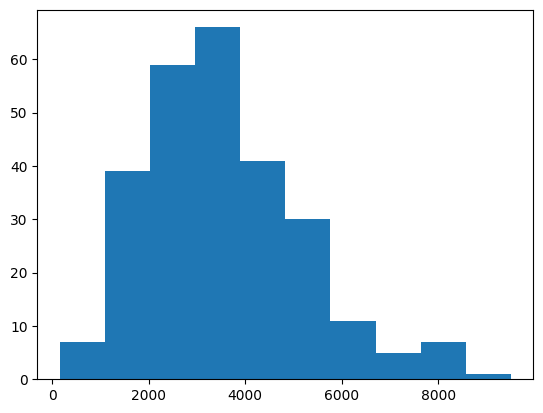

In [8]:
from matplotlib import pyplot as plt
u,c = np.unique(super0, return_counts=True)
plt.hist(c)

In [3]:
import numpy as np
import colorsys

def index_to_color(indices):
    """
    Map integer indices to vibrant RGB colors.

    Parameters
    ----------
    indices : int or array-like of ints
        Input index or indices. Can be a scalar or an iterable of ints.

    Returns
    -------
    colors : ndarray of shape (N, 3)
        RGB colors in the range [0, 1], where N is the number of indices.
    """
    # Ensure array of ints
    indices = np.atleast_1d(np.array(indices, dtype=int).flatten())
    
    # Use the golden ratio conjugate to spread hues evenly
    phi = 0.618033988749895
    hues = (indices * phi) % 1.0
    
    # Vibrancy settings
    s, v = 0.9, 0.95  # saturation and value
    
    # Convert each hue to RGB
    colors = np.array([colorsys.hsv_to_rgb(h, s, v) for h in hues], dtype=float)
    return colors




In [4]:
import pyvista as pv
colors = index_to_color(super0)

plotter = pv.Plotter(notebook=True)

poly = pv.PolyData(pos)
poly['rgb'] = colors

plotter.add_mesh(poly, scalars='rgb',rgb=True)

plotter.show(jupyter_backend='trame')


Widget(value='<iframe src="http://localhost:49770/index.html?ui=P_0x21b70a36900_0&reconnect=auto" class="pyvis…

In [5]:
import numpy as np
import maxflow
from sklearn.mixture import BayesianGaussianMixture

class GraphCutDPGMM:
    def __init__(self, features, edges, smoothing_beta=1.0, pairwise_lambda=1.0,
                 dp_alpha=1.0, max_components=10):
        self.features = features
        self.V, self.F = features.shape
        self.first_edge, self.adj_vertices = edges
        self.beta =smoothing_beta
        self.lmbda = pairwise_lambda
        self.max_components = max_components

        common_kwargs = dict(
            weight_concentration_prior_type = 'dirichlet_process',
            weight_concentration_prior=dp_alpha,
            n_components=max_components,
            covariance_type='full',
            max_iter=100,
            random_state=0
        )
        self.model_fg = BayesianGaussianMixture(**common_kwargs) # type:ignore
        self.model_bg = BayesianGaussianMixture(**common_kwargs) # type:ignore
        n_init = min(self.V, max_components)
        init_indices = np.random.RandomState(0).choice(self.V, size=n_init, replace=False)
        dummy = self.features[init_indices]
        self.model_fg.fit(dummy)
        self.model_bg.fit(dummy)

    def update_clicks(self, pos_indices, neg_indices):
        if len(pos_indices) > 0:
            Xp = self.features[pos_indices]
            k_fg = min(len(pos_indices), self.max_components)
            self.model_fg.set_params(n_components=k_fg)
            self.model_fg.fit(Xp)

        if len(neg_indices) > 0:
            Xn = self.features[neg_indices]
            k_bg = min(len(neg_indices), self.max_components)
            self.model_bg.set_params(n_components=k_bg)
            self.model_bg.fit(Xn)

    def compute_unary(self):
        logp_fg = self.model_fg.score_samples(self.features)
        logp_bg = self.model_bg.score_samples(self.features)
        cost_source = -logp_fg  # cost source[u]    = -log P(x_u | fg)
        cost_sink   = -logp_bg  # cost_sink[u]      = -log P(x_u | bg)

        return cost_source, cost_sink
    
    def build_graph(self, cost_source, cost_sink):
        g = maxflow.Graph[float](self.V, self.adj_vertices.size)
        nodeids = g.add_nodes(self.V)
        # t-links
        for u in range(self.V):
            g.add_tedge(u, cost_source[u], cost_sink[u])
        # pairwise edges
        fe, av = self.first_edge, self.adj_vertices
        for u in range(self.V):
            start, end = fe[u], fe[u+1]
            fu = self.features[u]
            for idx in range(start, end):
                v = av[idx]
                # weight = lambda * exp(-beta * ||f_u - f_v||^2)
                diff = fu - self.features[v]
                w = self.lmbda * np.exp(-self.beta * (diff @ diff))
                g.add_edge(u,v,w,w)
        return g
    
    def solve(self):
        cs, ct = self.compute_unary()
        g = self.build_graph(cs, ct)
        flow = g.maxflow()
        labels = np.array([g.get_segment(u) for u in range(self.V)])
        return labels.astype(bool)
    


        


In [20]:
super0

array([135, 135, 135, ...,  41,  41,  41], shape=(942188,), dtype=uint32)

In [6]:
from torch_scatter import scatter_mean

G = super0.max()+1
evals, evecs = scatter_eigendecomposition(
    src = torch.as_tensor(pos-pos.mean(axis=0),dtype=torch.float32),
    index = torch.as_tensor(super0,dtype=torch.int64),
    G = G
)

eps = 1e-5
# eigenvalues sorted ascending: l1 ≤ l2 ≤ l3
l1, l2, l3 = evals[:, 0], evals[:, 1], evals[:, 2]
# geometric features
linearity  = (l3 - l2) / (l3 + eps)
planarity  = (l2 - l1) / (l3 + eps)
scattering = l1 / (l3 + eps)

normals = evecs[:, :, 0]  # [N, 3]
verticality = normals[:, 2].abs()

mean_color = scatter_mean(
    torch.as_tensor(colors,dtype=torch.float32),
    torch.as_tensor(super0,dtype=torch.int64), dim=0, 
    dim_size=G)

# stack all features: [N, 7]
feats = torch.stack([linearity, planarity, scattering, verticality,
                        mean_color[:, 0], mean_color[:, 1], mean_color[:, 2]], dim=1).numpy()


In [7]:
gc = GraphCutDPGMM(feats, (edges0[0],edges0[1]))

c:\Users\Hristo\anaconda3\envs\3dapp\Lib\site-packages\joblib\externals\loky\backend\context.py:131: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\Hristo\anaconda3\envs\3dapp\Lib\site-packages\joblib\externals\loky\backend\context.py", line 255, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


In [8]:
pos_clicks = [10, 20, 30]
neg_clicks = [100, 110]

gc.update_clicks(pos_clicks, neg_clicks)
fg_mask = gc.solve()